<a href="https://colab.research.google.com/github/2hg7274/CodeStates/blob/main/Section2%20Project/Loan_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Prediction Based on Customer Behavior

# 라이브러리 호출

In [78]:
pip install category_encoders

In [79]:
pip install eli5

In [133]:
pip install pdpbox

     |████████████████████████████████| 34.0 MB 125 kB/s 
     |████████████████████████████████| 13.1 MB 5.8 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=afc2e1610f256fe3e9fdd8d85f0e2bebdc4e3f54271802c3fb812710fb7b6ae2
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [150]:
pip install shap

     |████████████████████████████████| 564 kB 5.3 MB/s 


In [80]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score

from sklearn.preprocessing import MinMaxScaler
from category_encoders import OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.base import BaseEstimator

import eli5
from eli5.sklearn import PermutationImportance

# 데이터 불러오기

In [81]:
train = pd.read_csv('https://raw.githubusercontent.com/2hg7274/CodeStates/main/Section2%20Project/Data/Training%20Data.csv')
test = pd.read_csv('https://raw.githubusercontent.com/2hg7274/CodeStates/main/Section2%20Project/Data/Test%20Data.csv')
sample_prediction = pd.read_csv('https://raw.githubusercontent.com/2hg7274/CodeStates/main/Section2%20Project/Data/Sample%20Prediction%20Dataset.csv')

In [82]:
print('train 데이터 형태: ', train.shape)
print('test 데이터 형태: ', test.shape)

train 데이터 형태:  (252000, 13)
test 데이터 형태:  (28000, 12)


In [83]:
train.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [84]:
test.head()

,ID,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11


In [85]:
# train데이터와 test데이터의 ID 컬럼 동일시 하기 위해 컬럼명 변경
train.rename(columns={'Id':'ID'}, inplace=True)

# Data Proprocessing

## 중복 ID 검사

In [86]:
def analysis_on_features(df):
    '''
    데이터 프레임에 중복된 Id가 있는지 파악
    '''
    duplicated_rows = 0
    dupli = df.duplicated(subset=['ID'])
    for i in dupli.index:
        if dupli[i] == True:
            duplicated_rows += 1
            print(i)
    
    return duplicated_rows

In [87]:
train_duplicated_rows = analysis_on_features(train)
test_duplicated_rows = analysis_on_features(test)

print('train 데이터의 중복열 개수는 {}개 이다.' .format(train_duplicated_rows))
print('test 데이터의 중복열 개수는 {}개 이다.' .format(test_duplicated_rows))

train 데이터의 중복열 개수는 0개 이다.
test 데이터의 중복열 개수는 0개 이다.


## Feature Engineering 및 Preprocessing

### 직업 그룹화

In [88]:
train['Profession'].unique()

array(['Mechanical_engineer', 'Software_Developer', 'Technical_writer',
       'Civil_servant', 'Librarian', 'Economist', 'Flight_attendant',
       'Architect', 'Designer', 'Physician', 'Financial_Analyst',
       'Air_traffic_controller', 'Politician', 'Police_officer', 'Artist',
       'Surveyor', 'Design_Engineer', 'Chemical_engineer',
       'Hotel_Manager', 'Dentist', 'Comedian', 'Biomedical_Engineer',
       'Graphic_Designer', 'Computer_hardware_engineer',
       'Petroleum_Engineer', 'Secretary', 'Computer_operator',
       'Chartered_Accountant', 'Technician', 'Microbiologist',
       'Fashion_Designer', 'Aviator', 'Psychologist', 'Magistrate',
       'Lawyer', 'Firefighter', 'Engineer', 'Official', 'Analyst',
       'Geologist', 'Drafter', 'Statistician', 'Web_designer',
       'Consultant', 'Chef', 'Army_officer', 'Surgeon', 'Scientist',
       'Civil_engineer', 'Industrial_Engineer', 'Technology_specialist'],
      dtype=object)

- 의사(medical) -> 'Physician', 'Surgeon', 'Dentist'<br><br>

- 공직자(public) -> 'Civil_servant', 'Librarian', 'Politician', 'Police_officer', 'Magistrate', 'Firefighter', 'Official', 'Army_officer', 'Chartered_Accountant'  <br><br>

- 기계 & 건축 & 엔지니어(eng) -> 'Mechanical_engineer', 'Architect', 'Surveyor', 'Design_Engineer', 'Chemical_engineer', 'Biomedical_Engineer', Petroleum_Engineer’, 'Technician', 'Engineer'<br><br>

- IT(IT) - > 'Software_Developer', 'Graphic_Designer', 'Computer_hardware_engineer', 'Computer_operator', 'Web_designer', 'Technical_writer'<br><br>

- 예술(artfical) -> 'Designer', 'Artist', 'Comedian', 'Fashion_Designer'<br><br>  

- 전문직(pro) - > 'Economist', 'Flight_attendant', 'Financial_Analyst', 'Air_traffic_controller', 'Hotel_Manager', 'Secretary', 'Aviator', 'Lawyer', 'Analyst', 'Drafter', 'Consultant', 'Chef', 'Civil_engineer', 'Industrial_Engineer', 'Technology_specialist'<br><br>

- 학계(scholar) -> 'Microbiologist', 'Psychologist', 'Geologist', 'Statistician', 'Scientist'

In [89]:
pro_dic = {
    'Medical': 0,
    'Public': 0,
    'Eng': 0,
    'IT': 0,
    'Art': 0,
    'Pro': 0,
    'Scholar': 0
}

pro_dic['Medical'] = ['Physician', 'Surgeon', 'Dentist']
pro_dic['Public'] = ['Civil_servant', 'Librarian', 'Politician', 'Police_officer', 'Magistrate', 
            'Firefighter', 'Official', 'Army_officer', 'Chartered_Accountant']
pro_dic['Eng'] = ['Mechanical_engineer', 'Architect', 'Surveyor', 'Design_Engineer', 'Chemical_engineer', 
        'Biomedical_Engineer', 'Petroleum_Engineer', 'Technician' ,'Engineer']
pro_dic['IT'] = ['Software_Developer', 'Graphic_Designer', 'Computer_hardware_engineer', 
        'Computer_operator', 'Web_designer','Technical_writer']
pro_dic['Art'] = ['Designer', 'Artist', 'Comedian', 'Fashion_Designer']
pro_dic['Pro'] = ['Economist', 'Flight_attendant', 'Financial_Analyst', 'Air_traffic_controller', 'Hotel_Manager', 
        'Secretary', 'Aviator', 'Lawyer', 'Analyst', 'Drafter', 'Consultant', 'Chef', 'Civil_engineer', 'Industrial_Engineer', 
        'Technology_specialist']
pro_dic['Scholar'] = ['Microbiologist', 'Psychologist', 'Geologist', 'Statistician', 'Scientist']

### 주(STATE) 그룹화

In [90]:
train['STATE'].unique()

array(['Madhya_Pradesh', 'Maharashtra', 'Kerala', 'Odisha', 'Tamil_Nadu',
       'Gujarat', 'Rajasthan', 'Telangana', 'Bihar', 'Andhra_Pradesh',
       'West_Bengal', 'Haryana', 'Puducherry', 'Karnataka',
       'Uttar_Pradesh', 'Himachal_Pradesh', 'Punjab', 'Tripura',
       'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam',
       'Jammu_and_Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh',
       'Uttar_Pradesh[5]', 'Manipur', 'Sikkim'], dtype=object)

- 북인도(NI) -> 'Madhya_Pradesh', 'Rajasthan', 'Haryana', 'Uttar_Pradesh', 'Himachal_Pradesh', 'Punjab', 'Uttarakhand', 'Jammu_and_Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh', 'Uttar_Pradesh' 

- 서인도(WI) -> 'Maharashtra', 'Gujarat'

- 남인도(SI) -> 'Kerala', 'Tamil_Nadu', 'Telangana', 'Andhra_Pradesh', 'Puducherry', 'Karnataka' 

- 동인도(EI) -> 'Odisha', 'Bihar', 'West_Bengal', 'Jharkhand'

- 북동인도(NEI) -> 'Tripura', 'Mizoram', 'Assam', 'Manipur', 'Sikkim'  

In [91]:
state_dic = {
    'NI': 0,
    'WI': 0,
    'SI': 0,
    'EI': 0,
    'NEI': 0
}

state_dic['NI'] = ['Madhya_Pradesh', 'Rajasthan', 'Haryana', 'Uttar_Pradesh', 
    'Himachal_Pradesh', 'Punjab', 'Uttarakhand', 'Jammu_and_Kashmir', 'Delhi', 'Chhattisgarh', 
    'Chandigarh', 'Uttar_Pradesh']
state_dic['WI'] = ['Maharashtra', 'Gujarat']
state_dic['SI'] = ['Kerala', 'Tamil_Nadu', 'Telangana', 'Andhra_Pradesh', 'Puducherry', 'Karnataka']
state_dic['EI'] = ['Odisha', 'Bihar', 'West_Bengal', 'Jharkhand']
state_dic['NEI'] = ['Tripura', 'Mizoram', 'Assam', 'Manipur', 'Sikkim']

In [92]:
# profession 바꾸는 함수
def change_pro(data):
    for key, value in pro_dic.items():
        for i in value:
            if data == i:
                data = key
    return data


# state 바꾸는 함수
def change_state(data):
    for key, value in state_dic.items():
        for j in value:
            if data == j:
                data = key
    
    return data


# 전처리 함수
def eda_preprocess(df):
    # 분석에 사용하지 않을 'ID' 컬럼 삭제
    df = df.drop(['ID'], axis=1)

    # 'CITY'컬럼 삭제 -> 너무 높은 카디널리티
    df = df.drop(['CITY'], axis=1)

    # 'Profession' 컬럼 값 그룹화하기
    df['Profession'] = df['Profession'].apply(change_pro)
        
    # 'STATE'컬럼 값 그룹화하기
    df['STATE'] = df['STATE'].apply(change_state)

    # 'OutofWork_time' -> 직장이 없던 기간
    df['OutofWork_time'] = df['Experience'] - df['CURRENT_JOB_YRS']
    
    return df



In [93]:
train_processed = eda_preprocess(train.copy())
test_processed = eda_preprocess(test.copy())

In [94]:
train_processed

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,OutofWork_time
0,1303834,23,3,single,rented,no,Eng,NI,3,13,0,0
1,7574516,40,10,single,rented,no,IT,WI,9,13,0,1
2,3991815,66,4,married,rented,no,IT,SI,4,10,0,0
3,6256451,41,2,single,rented,yes,IT,EI,2,12,1,0
4,5768871,47,11,single,rented,no,Public,SI,3,14,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...
251995,8154883,43,13,single,rented,no,Medical,EI,6,11,0,7
251996,2843572,26,10,single,rented,no,Public,NI,6,11,0,4
251997,4522448,46,7,single,rented,no,Eng,WI,7,12,0,0
251998,6507128,45,0,single,rented,no,IT,SI,0,10,0,0


# Modeling - Income 예측

## 변수 및 모델 정의

In [95]:
train1 = train_processed.copy()
test1 = test_processed.copy()

train1 = train1.drop(['Risk_Flag'], axis=1)
train1.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,OutofWork_time
0,1303834,23,3,single,rented,no,Eng,NI,3,13,0
1,7574516,40,10,single,rented,no,IT,WI,9,13,1
2,3991815,66,4,married,rented,no,IT,SI,4,10,0
3,6256451,41,2,single,rented,yes,IT,EI,2,12,0
4,5768871,47,11,single,rented,no,Public,SI,3,14,8


In [96]:
# train, vl 데이터 나누는 함수
def split(df, target):
    X = df.drop([target], axis=1)
    y = df[target]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [97]:
X_train, X_val, y_train, y_val = split(train1, 'Income')

In [98]:
print('X_train의 형태: ', X_train.shape)
print('X_val의 형태: ', X_val.shape)


X_train의 형태:  (201600, 10)
X_val의 형태:  (50400, 10)


In [99]:
# 조정된 결정계수 r2 구하는 함수 
def adj_r2(r2, n, p):
    return 1 - (1-r2)*(n-1)/(n-p-1)

#### 기준모델

In [100]:
# 기준 모델 
# 평가지표는 MAE
mae_r2_score = {}
baseline_predict = [train1['Income'].mean()]*len(X_val)

baseline_mae = mean_absolute_error(y_val, baseline_predict)
baseline_r2 = r2_score(y_val, baseline_predict)
baseline_adj_r2 = adj_r2(baseline_r2, X_val.shape[0], X_val.shape[1])

mae_r2_score['baseline'] = [baseline_mae, baseline_r2, baseline_adj_r2]

#### LinearRegression

In [101]:
# LinearRegression
onehot = OneHotEncoder(use_cat_names=True)
X_train_encoded = onehot.fit_transform(X_train)
X_val_encoded = onehot.transform(X_val)

pipe_LinearR = Pipeline([
    ('mn_scale', MinMaxScaler()),
    ('LinearRegreesion', LinearRegression(n_jobs=-1))
])
pipe_LinearR.fit(X_train_encoded, y_train)
LinearRegression_pred = pipe_LinearR.predict(X_val_encoded)

LinearRegression_mae = mean_absolute_error(y_val, LinearRegression_pred)
LinearRegression_r2 = r2_score(y_val, LinearRegression_pred)
LinearRegression_adj_r2 = adj_r2(LinearRegression_r2, X_val_encoded.shape[0], X_val_encoded.shape[1])


mae_r2_score['LinearRegression'] = [LinearRegression_mae, LinearRegression_r2, LinearRegression_adj_r2]


#### RidgeCV

In [102]:
# RidgeCV
pipe_Ridge = Pipeline([
    ('mn_scale', MinMaxScaler()),
    ('ridge', RidgeCV())
])
pipe_Ridge.fit(X_train_encoded, y_train)
RidgeCV_pred = pipe_Ridge.predict(X_val_encoded)

RidgeCV_mae = mean_absolute_error(y_val, RidgeCV_pred)
RidgeCV_r2 = r2_score(y_val, RidgeCV_pred)
RidgeCV_adj_r2 = adj_r2(RidgeCV_r2, X_val_encoded.shape[0], X_val_encoded.shape[1])

mae_r2_score['RidgeCV'] = [RidgeCV_mae, RidgeCV_r2, RidgeCV_adj_r2]

#### RandomForestRegressor

In [103]:
# RnadomforestRegressor
pipe_RFR = Pipeline([
    ('ordinal', OrdinalEncoder()),
    ('RFregressor', RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42))
])
dists_RFr = {
    'RFregressor__max_depth': [10, 15, 20],
    'RFregressor__min_samples_split': [2, 3, 4],
    'RFregressor__min_samples_leaf': [1, 2, 3]
}

clf_RFr = RandomizedSearchCV(
    pipe_RFR,
    param_distributions=dists_RFr,
    n_iter=10,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42
)

clf_RFr.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_RFr.best_params_, '\n')
print('MAE: ', -clf_RFr.best_score_)


최적 하퍼라미터:  {'RFregressor__min_samples_split': 2, 'RFregressor__min_samples_leaf': 2, 'RFregressor__max_depth': 20} 

MAE:  708719.693347021


In [104]:
pipe_RFR = clf_RFr.best_estimator_
RFregressor_pred = pipe_RFR.predict(X_val)

RFregressor_mae = mean_absolute_error(y_val, RFregressor_pred)
RFregressor_r2 = r2_score(y_val, RFregressor_pred)
RFregressor_adj_r2 = adj_r2(RFregressor_r2, X_val.shape[0], X_val.shape[1])

mae_r2_score['RandomForestRegressor'] = [RFregressor_mae, RFregressor_r2, RFregressor_adj_r2]


#### XGBRegressor

In [105]:
class XGBoostWithEarlyStopLinear(BaseEstimator):
    def __init__(self, early_stopping_rounds=7, test_size=0.2, 
                 eval_metric='mae',n_jobs=-1, random_state=42, **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric='mae'      
        self.n_jobs=n_jobs
        self.random_state=random_state  
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=42)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStopLinear):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)

In [106]:
# XGBRegressor
pipe_XGBR = Pipeline([
    ('ordinal', OrdinalEncoder()),
    ('XGBR', XGBoostRegressorWithEarlyStop())
])

dists_XGBr = {
    'XGBR__max_depth': [10, 15, 20],
    'XGBR__max_leaves': [1, 2, 3,],
    'XGBR__learning_rate': [0.1, 0.2]
}

clf_XGBr= RandomizedSearchCV(
    pipe_XGBR,
    param_distributions=dists_XGBr,
    n_iter=5,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42
)

clf_XGBr.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_XGBr.best_params_, '\n')
print('MAE: ', -clf_XGBr.best_score_)


[03:31:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:4.52821e+06
Will train until validation_0-mae hasn't improved in 7 rounds.
[1]	validation_0-mae:4.13242e+06
[2]	validation_0-mae:3.80209e+06
[3]	validation_0-mae:3.52665e+06
[4]	validation_0-mae:3.30116e+06
[5]	validation_0-mae:3.10785e+06
[6]	validation_0-mae:2.95436e+06
[7]	validation_0-mae:2.81193e+06
[8]	validation_0-mae:2.69597e+06
[9]	validation_0-mae:2.59126e+06
[10]	validation_0-mae:2.50897e+06
[11]	validation_0-mae:2.4324e+06
[12]	validation_0-mae:2.3731e+06
[13]	validation_0-mae:2.31146e+06
[14]	validation_0-mae:2.25697e+06
[15]	validation_0-mae:2.21194e+06
[16]	validation_0-mae:2.17786e+06
[17]	validation_0-mae:2.13425e+06
[18]	validation_0-mae:2.09747e+06
[19]	validation_0-mae:2.06317e+06
[20]	validation_0-mae:2.02916e+06
[21]	validation_0-mae:2.00741e+06
[22]	validation_0-mae:1.97322e+06
[23]	validation_0-mae:1.94611e+06
[24]	v

In [107]:
pipe_XGBR = clf_XGBr.best_estimator_
pipe_XGBR.fit(X_train, y_train)
XGBR_pred = pipe_XGBR.predict(X_val)

XGBR_mae = mean_absolute_error(y_val, XGBR_pred)
XGBR_r2 = r2_score(y_val, XGBR_pred)
XGBR_adj_r2 = adj_r2(XGBR_r2, X_val.shape[0], X_val.shape[1])

mae_r2_score['XGBRegressor'] = [XGBR_mae, XGBR_r2, XGBR_adj_r2]

[03:51:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:4.53171e+06
Will train until validation_0-mae hasn't improved in 7 rounds.
[1]	validation_0-mae:4.10581e+06
[2]	validation_0-mae:3.72761e+06
[3]	validation_0-mae:3.38659e+06
[4]	validation_0-mae:3.08367e+06
[5]	validation_0-mae:2.81403e+06
[6]	validation_0-mae:2.5719e+06
[7]	validation_0-mae:2.35531e+06
[8]	validation_0-mae:2.16195e+06
[9]	validation_0-mae:1.98617e+06
[10]	validation_0-mae:1.83012e+06
[11]	validation_0-mae:1.69093e+06
[12]	validation_0-mae:1.56454e+06
[13]	validation_0-mae:1.45244e+06
[14]	validation_0-mae:1.35231e+06
[15]	validation_0-mae:1.26259e+06
[16]	validation_0-mae:1.18275e+06
[17]	validation_0-mae:1.10937e+06
[18]	validation_0-mae:1.04118e+06
[19]	validation_0-mae:981730
[20]	validation_0-mae:926759
[21]	validation_0-mae:882044
[22]	validation_0-mae:840777
[23]	validation_0-mae:803757
[24]	validation_0-mae:770288
[

In [108]:
# 모델들의 mae와 r2 비교 
mae_r2_score

{'LinearRegression': [2482857.3881349205,
  0.0010916435883275843,
  0.0005958975901877439],
 'RandomForestRegressor': [700732.3901609607,
  0.8099960289386787,
  0.809958321508275],
 'RidgeCV': [2482850.850584965, 0.0010954854360776256, 0.0005997413445999467],
 'XGBRegressor': [415441.67011835007, 0.8030044939663394, 0.8029653990237857],
 'baseline': [2484726.918723612,
  -2.553989657316791e-05,
  -0.0002240009773439855]}

## 모델 선택
결정 계수 R2와 조정된 결정계수 adj_R2만 본다면 'RandomForestRegressor'모델이 가장 성능이 좋아 보인다.  
그런데 'XGBRegressor'와 0.007정도의 차이만 있으며, XGBRegressor의 MAE가 RandomForestRegressor보다 약 285291정도의 차이만큼 작다.  
따라서 ***XGBRegressor모델***을 선택하는 것이 더 바람직하다고 생각한다.  

### 가장 좋은 모델의 성능 확인

In [109]:
# test 데이터로 모델 성능 확인
Income_test = test1['Income']
test1_1 = test1.drop(['Income'], axis=1)
test1_1.head()

,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,OutofWork_time
0,59,19,single,rented,no,Scholar,West Bengal,4,13,15
1,25,5,single,rented,no,Public,WI,5,10,0
2,50,12,single,rented,no,Pro,WI,9,14,3
3,49,9,married,rented,yes,Pro,WI,3,12,6
4,25,18,single,rented,yes,Art,West Bengal,13,11,5


In [110]:
blm_pred = pipe_XGBR.predict(test1_1)

blm_mae = mean_absolute_error(Income_test, blm_pred)
blm_r2 = r2_score(Income_test, blm_pred)
blm_adj_r2 = adj_r2(blm_r2, test1.shape[0], test1.shape[1])

print(f' XGBRegressor의 예측 성능-> MAE: {blm_mae}, r2: {blm_r2}, adj_r2: {blm_adj_r2}')

 XGBRegressor의 예측 성능-> MAE: 1551588.1787794363, r2: 0.32509259805282775, adj_r2: 0.3248273421781165


# Modeling - Risk_Flag 예측

## 변수 및 모델 정의

In [111]:
train2 = train_processed.copy()
test2 = test_processed.copy()

# test2의 'Income'값을 위에서 에측한 값으로 변경
test2['Income'] = blm_pred

In [112]:
X_train, X_val, y_train, y_val = split(train2, 'Risk_Flag')

In [113]:
print('X_train의 형태: ', X_train.shape)
print('X_val의 형태: ', X_val.shape)


X_train의 형태:  (201600, 11)
X_val의 형태:  (50400, 11)


#### 기준 모델

In [114]:
# 기준 모델
# 평가지표는 accuracy, f1 score
acc_f1_score = {}

baseline_predict = [train2['Risk_Flag'].mode()[0]]*len(X_val)

baseline_acc = accuracy_score(y_val, baseline_predict)
baseline_f1 = f1_score(y_val, baseline_predict)

acc_f1_score['baseline'] = [baseline_acc, baseline_f1]


#### LogisticRegression

In [115]:
# LogisticRegression
onehot = OneHotEncoder(use_cat_names=True)
X_train_encoded2 = onehot.fit_transform(X_train)
X_val_encoded2 = onehot.transform(X_val)


pipe_LogisticR = Pipeline([
    ('logistic', LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42))
])

dists_LR = {
    'logistic__C': [1.0, 2.0, 3.0],
    'logistic__solver': ['lbfgs', 'liblinear', 'saga']
}

clf_LR = RandomizedSearchCV(
    pipe_LogisticR,
    param_distributions=dists_LR,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_LR.fit(X_train_encoded2, y_train)
print('최적 하퍼라미터: ', clf_LR.best_params_, '\n')
print('Accuracy ', clf_LR.best_score_)


최적 하퍼라미터:  {'logistic__solver': 'saga', 'logistic__C': 1.0} 

Accuracy  0.7267311507936508


In [116]:
pipe_LogisticR = clf_LR.best_estimator_
LR_pred = pipe_LogisticR.predict(X_val_encoded2)

LR_acc = accuracy_score(y_val, LR_pred)
LR_f1 = f1_score(y_val, LR_pred)

acc_f1_score['LogisticRegression'] = [LR_acc, LR_f1]

#### RandomForestClassifier

In [117]:
# RandomForestClassifier
pipe_RFC = Pipeline([
    ('ordinal', OrdinalEncoder()),
    ('RFclassifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True, random_state=42))
])

dists_RFC = {
    'RFclassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'RFclassifier__max_depth': [10, 15, 20],
    'RFclassifier__min_samples_split': [2, 3, 4],
    'RFclassifier__min_samples_leaf': [1, 2, 3],
    'RFclassifier__max_features': ['sqrt', 'log2']
}

clf_RFC = RandomizedSearchCV(
    pipe_RFC,
    param_distributions=dists_RFC,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_RFC.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_RFC.best_params_, '\n')
print('Accuracy ', clf_RFC.best_score_)


최적 하퍼라미터:  {'RFclassifier__min_samples_split': 4, 'RFclassifier__min_samples_leaf': 1, 'RFclassifier__max_features': 'log2', 'RFclassifier__max_depth': 20, 'RFclassifier__criterion': 'entropy'} 

Accuracy  0.8951587301587303


In [118]:
pipe_RFC = clf_RFC.best_estimator_
RFC_pred = pipe_RFC.predict(X_val)

RFC_acc = accuracy_score(y_val, RFC_pred)
RFC_f1 = f1_score(y_val, RFC_pred)

acc_f1_score['RandomForestClassifier'] = [RFC_acc, RFC_f1]

#### XGBoostClassifier

In [119]:
class XGBoostWithEarlyStopClassifier(BaseEstimator):
    def __init__(self, early_stopping_rounds=7, test_size=0.2, 
                 eval_metric='error', scale_pos_weight=7, n_jobs=-1, random_state=42, **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric='error' 
        self.scale_pos_weight = scale_pos_weight
        self.n_jobs = n_jobs       
        self.random_state = random_state
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=42)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStopClassifier):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [120]:
# XGBClassifier
pipe_XGBC = Pipeline([
    ('ordinal', OrdinalEncoder()),
    ('XGBC', XGBoostClassifierWithEarlyStop())
])

dists_XGBc = {
    'XGBC__max_depth': [10, 15, 20],
    'XGBC__max_leaves': [1, 2, 3,],
    'XGBC__learning_rate': [0.1, 0.2]
}

clf_XGBc= RandomizedSearchCV(
    pipe_XGBC,
    param_distributions=dists_XGBc,
    n_iter=5,
    cv=5,
    scoring='accuracy',
    random_state=42
)

clf_XGBc.fit(X_train, y_train)
print('최적 하퍼라미터: ', clf_XGBc.best_params_, '\n')
print('Accuracy: ', clf_XGBc.best_score_)


[0]	validation_0-error:0.122024
Will train until validation_0-error hasn't improved in 7 rounds.
[1]	validation_0-error:0.121652
[2]	validation_0-error:0.121373
[3]	validation_0-error:0.121559
[4]	validation_0-error:0.121063
[5]	validation_0-error:0.121311
[6]	validation_0-error:0.121187
[7]	validation_0-error:0.121497
[8]	validation_0-error:0.121435
[9]	validation_0-error:0.121714
[10]	validation_0-error:0.121931
[11]	validation_0-error:0.121714
Stopping. Best iteration:
[4]	validation_0-error:0.121063

[0]	validation_0-error:0.120319
Will train until validation_0-error hasn't improved in 7 rounds.
[1]	validation_0-error:0.120133
[2]	validation_0-error:0.120412
[3]	validation_0-error:0.120102
[4]	validation_0-error:0.120288
[5]	validation_0-error:0.120443
[6]	validation_0-error:0.120071
[7]	validation_0-error:0.119513
[8]	validation_0-error:0.11942
[9]	validation_0-error:0.119699
[10]	validation_0-error:0.119761
[11]	validation_0-error:0.119823
[12]	validation_0-error:0.120071
[13]	va

In [121]:
pipe_XGBC = clf_XGBc.best_estimator_
pipe_XGBC.fit(X_train, y_train)
XGBC_pred = pipe_XGBC.predict(X_val)

XGBC_acc = accuracy_score(y_val, XGBC_pred),
XGBC_f1 = f1_score(y_val, XGBC_pred)

acc_f1_score['XGBClassifier'] = [XGBC_acc, XGBC_f1]

[0]	validation_0-error:0.109896
Will train until validation_0-error hasn't improved in 7 rounds.
[1]	validation_0-error:0.106002
[2]	validation_0-error:0.105655
[3]	validation_0-error:0.104762
[4]	validation_0-error:0.105208
[5]	validation_0-error:0.105134
[6]	validation_0-error:0.105531
[7]	validation_0-error:0.105134
[8]	validation_0-error:0.104563
[9]	validation_0-error:0.10496
[10]	validation_0-error:0.104291
[11]	validation_0-error:0.103993
[12]	validation_0-error:0.103745
[13]	validation_0-error:0.104142
[14]	validation_0-error:0.104439
[15]	validation_0-error:0.104241
[16]	validation_0-error:0.104911
[17]	validation_0-error:0.104812
[18]	validation_0-error:0.10506
[19]	validation_0-error:0.10568
Stopping. Best iteration:
[12]	validation_0-error:0.103745



In [122]:
# 모델들의 accuracy와 f1 비교 
acc_f1_score

{'LogisticRegression': [0.8759325396825397, 0.0],
 'RandomForestClassifier': [0.8936507936507937, 0.6417112299465241],
 'XGBClassifier': [(0.8939087301587302,), 0.4642821360585112],
 'baseline': [0.8759325396825397, 0.0]}

## 모델 선택
정확도 점수로 모델을 선택 한다면 XGBClassifier가 선택되어야 한다.  
하지만 f1점수를 보면 RandomForestClassifier가 더 높은 것을 알 수 있고, 정확도 또한 XGBClassifier와 차이가 심하지 않다.  
따라서 ***RnadomForestClassifier모델***을 선택한다.  

### 가장 좋은 모델의 성능 확인

In [123]:
# test 데이터로 모델 성능 확인
test2.head()

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,OutofWork_time
0,5756145.000,59,19,single,rented,no,Scholar,West Bengal,4,13,15
1,1216729.625,25,5,single,rented,no,Public,WI,5,10,0
2,8880436.000,50,12,single,rented,no,Pro,WI,9,14,3
3,5634136.000,49,9,married,rented,yes,Pro,WI,3,12,6
4,2468215.000,25,18,single,rented,yes,Art,West Bengal,13,11,5


In [124]:
Risk_Flag_test = sample_prediction
Risk_flag = Risk_Flag_test['risk_flag']

In [125]:
blm_pred = pipe_RFC.predict(test2)

blm_acc = accuracy_score(Risk_flag, blm_pred)
blm_f1 = f1_score(Risk_flag, blm_pred)


print(f' RandomForestClassifier의 예측 성능-> Accuracty: {blm_acc}, F-1 Score: {blm_f1}')

 RandomForestClassifier의 예측 성능-> Accuracty: 0.8026785714285715, F-1 Score: 0.11387329591018444


In [126]:
print(classification_report(Risk_flag, blm_pred, target_names=['class 0', 'class 1']))


              precision    recall  f1-score   support

     class 0       0.87      0.91      0.89     24407
     class 1       0.13      0.10      0.11      3593

    accuracy                           0.80     28000
   macro avg       0.50      0.50      0.50     28000
weighted avg       0.78      0.80      0.79     28000



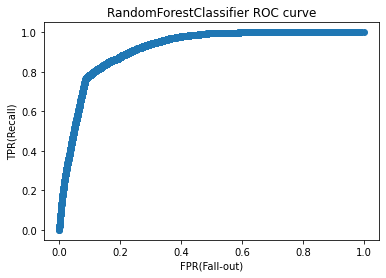

In [127]:
y_pred_proba_randomforest = pipe_RFC.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_randomforest)
roc = pd.DataFrame({
    'FPR(Fall-out)':fpr,
    'TPRate(Recall)':tpr,
    'Threshold':thresholds
})

plt.scatter(fpr, tpr)
plt.title('RandomForestClassifier ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')
plt.show()

In [128]:
# 최적의 threshold 찾기
optimal_idx_randomforest = np.argmax(tpr-fpr)
optimal_threshold_randomforest = thresholds[optimal_idx_randomforest]
print('idx: ', optimal_idx_randomforest, ', threshold: ', optimal_threshold_randomforest, '\n')

y_pred_optimal_randomforest = y_pred_proba_randomforest >= optimal_threshold_randomforest
print('최적의 threshold를 임계값으로 할 때')
print(classification_report(y_val, y_pred_optimal_randomforest), '\n')


y_pred_05 = y_pred_proba_randomforest >= 0.5
print('0.5 임계값으로 할 때')
print(classification_report(y_val, y_pred_05), '\n')

auc_score = roc_auc_score(y_val, y_pred_proba_randomforest)
print('RandomForestClassifier AUC Score: ',auc_score)

idx:  2009 , threshold:  0.35564186149582033 

최적의 threshold를 임계값으로 할 때
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     44147
           1       0.45      0.83      0.59      6253

    accuracy                           0.86     50400
   macro avg       0.71      0.84      0.75     50400
weighted avg       0.91      0.86      0.87     50400
 

0.5 임계값으로 할 때
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     44147
           1       0.55      0.77      0.64      6253

    accuracy                           0.89     50400
   macro avg       0.76      0.84      0.79     50400
weighted avg       0.91      0.89      0.90     50400
 

RandomForestClassifier AUC Score:  0.9179587220110925


In [129]:
test_pred_proba_RFC = pipe_RFC.predict_proba(test2)[:,1]

# 최적의 threshold를 기준으로 1과 0 분류
test_pred = []
for i in test_pred_proba_RFC:
    if i >= optimal_threshold_randomforest:
        a = 1
        test_pred.append(a)
    else:
        b = 0
        test_pred.append(b)

blm_acc2 = accuracy_score(Risk_flag, test_pred)
blm_f12 = f1_score(Risk_flag, test_pred)


print(f' RandomForestClassifier의 예측 성능-> Accuracty: {blm_acc2}, F-1 Score: {blm_f12}')

 RandomForestClassifier의 예측 성능-> Accuracty: 0.68875, F-1 Score: 0.1708686138331272


In [130]:
print(classification_report(Risk_flag, test_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.87      0.75      0.81     24407
     class 1       0.13      0.25      0.17      3593

    accuracy                           0.69     28000
   macro avg       0.50      0.50      0.49     28000
weighted avg       0.78      0.69      0.73     28000



# 모델 해석
모델의 예측 결과에 대해서 알아보자.  

최적의 임계값을 찾은 후 임계값보다 같거나 높은 것은 1, 작은 것은 0으로 다시 분류하였다.  

우선, 최종 모델의 예측 결과는 69%정도인 것을 알 수 있다.  
다만 이 모델은 0이라고 예측한 데이터의 87%가 실제 0이었고, 1이라고 예측한 데이터의 13%가 실제 1 이었음을 알 수 있다.  

임계값을 조절 후 Class 1의 recall 점수가 올라간 것을 알 수 있다.  
이는 실제 1일 때, 모델이 1이라고 예측한 것의 비율이 올라간 것을 알 수 있다.  
그리고 f1 score 또한 0.11 -> 0.17로 올라간 것을 알 수 있다.  

class1을 정확하게 분류하는 모델은 아니지만 은행의 입장에서 이 모델을 통해 대출을 해줄지 하지말지의 결정의 도움이 될 수 있을 것 같다고 판단한다.  

## Permutation Importance

In [131]:
permuter = PermutationImportance(
    pipe_RFC.named_steps['RFclassifier'],
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
X_val_transformed = pipe_RFC.named_steps['ordinal'].transform(X_val)
permuter.fit(X_val_transformed, y_val)

PermutationImportance(estimator=RandomForestClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=20,
                                                       max_features='log2',
                                                       min_samples_split=4,
                                                       n_jobs=-1,
                                                       oob_score=True,
                                                       random_state=42),
                      random_state=42, scoring='accuracy')

In [134]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)
p_i = sorted(
    list(zip(X_val.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True
)
print(p_i[:3])

[('Age', 0.01668650793650799), ('Income', 0.015178571428571463), ('Experience', 0.008865079365079409)]


## PDP 

In [145]:
def get_pdp_isolated(dataset, model, feature):
    pdp_isolated = pdp_isolate(
        model = model,
        dataset = dataset,
        model_features = dataset.columns,
        feature = feature,
        grid_type = 'percentile',
        num_grid_points = 10
    )

    return pdp_isolated

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6269f911d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6269fd9f90>})

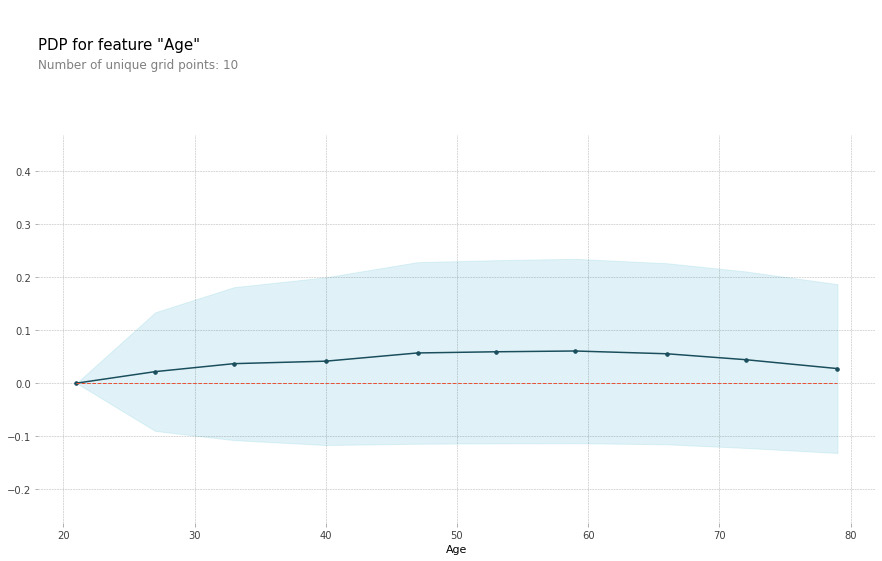

In [146]:
from pdpbox.pdp import pdp_isolate, pdp_plot

X_val_transformed_df = pd.DataFrame(X_val_transformed, columns=X_val.columns)
feature = sorted(p_i, key=lambda x: x[1], reverse=True)[0][0]
model = pipe_RFC.named_steps['RFclassifier']

pdp_isolated = get_pdp_isolated(X_val_transformed_df, model, feature)
pdp_plot(pdp_isolated, feature_name=feature)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6269fd3650>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6269fd3990>})

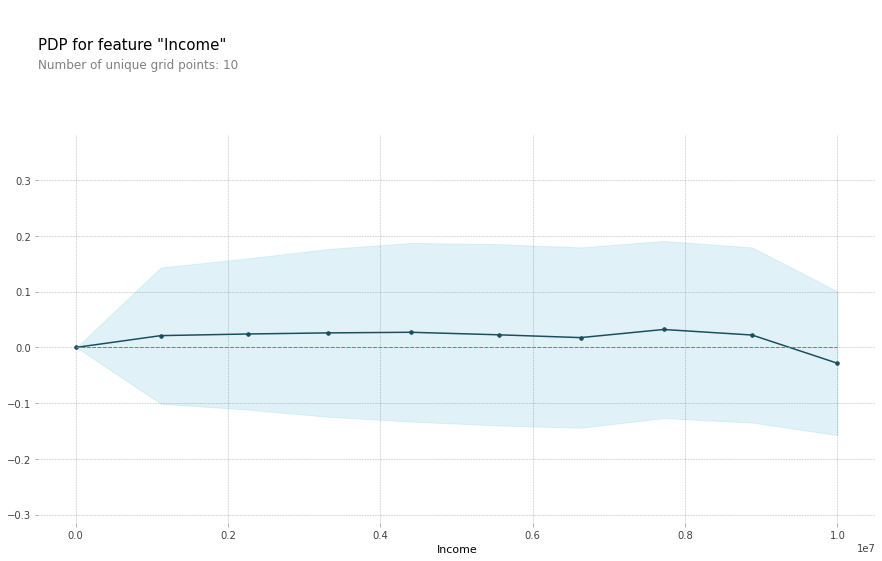

In [147]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = sorted(p_i, key=lambda x: x[1], reverse=True)[1][0]

pdp_isolated = get_pdp_isolated(X_val_transformed_df, model, feature)
pdp_plot(pdp_isolated, feature_name=feature)

In [148]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

def get_pdp_interaction(dataset, model, features):
    pdp_interaction = pdp_interact(
        model = model,
        dataset = dataset,
        model_features = dataset.columns,
        features = features
    ) 

    return pdp_interaction

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6269c1b310>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f6269b7f1d0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


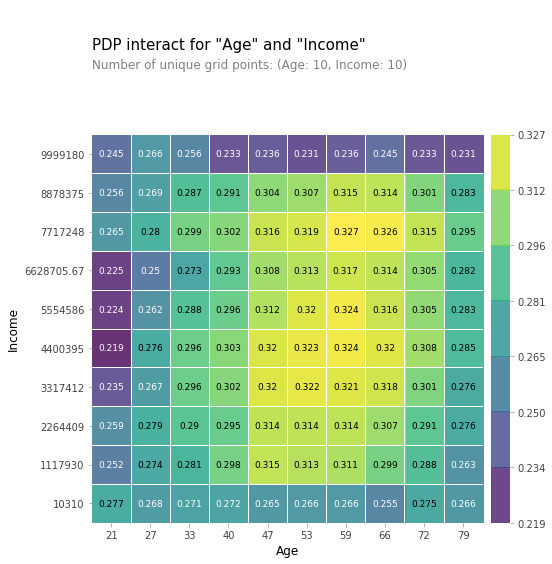

In [149]:
features = list(map(lambda x: x[0], sorted(p_i, key=lambda x: x[1], reverse=True)))[:2]
pdp_interaction = get_pdp_interaction(X_val_transformed_df, model, features)
pdp_interact_plot(pdp_interaction, feature_names=features, plot_type='grid')